In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [3]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [85]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/train/img/'
TEST_PATH = 'dataset/test/img/'

In [5]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [86]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]

In [20]:
len(train_ids)

130

In [87]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

Getting and resizing train images and masks ... 


In [88]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = 'dataset/train'
    img = imread(path + '/img/' + id_ )[:,:,:IMG_CHANNELS]
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = imread(path + '/gt/'+ id_ )[:,:,:1]
#     for mask_file in next(os.walk(path + '/gt/'))[2]:
#         mask_ = imread(path + '/gt/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)
    Y_train[n] = mask


100%|████████████████████████████████████████| 130/130 [00:01<00:00, 70.53it/s]


In [89]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = 'dataset/test'
    img = imread(path + '/img/' + id_)[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 108.04it/s]


Done!


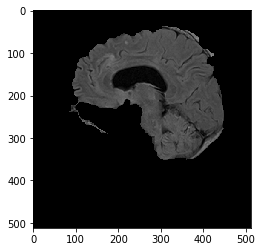

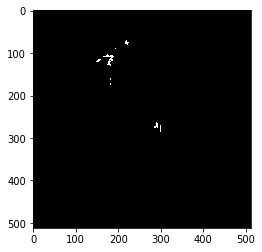

In [92]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]), cmap = 'gray')
plt.show()

In [29]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [67]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn
    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value


In [94]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 512, 512, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

In [95]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=1, epochs=20, 
                    callbacks=[earlystopper, checkpointer])

Train on 117 samples, validate on 13 samples
Epoch 1/50
117/117 [==============================] - ETA: 25:48 - loss: 0.7495 - mean_iou: 0.0000e+0 - ETA: 14:07 - loss: 0.6925 - mean_iou: 0.2276    - ETA: 10:13 - loss: 0.6222 - mean_iou: 0.306 - ETA: 8:14 - loss: 0.5469 - mean_iou: 0.348 - ETA: 7:03 - loss: 0.4762 - mean_iou: 0.37 - ETA: 6:14 - loss: 0.4134 - mean_iou: 0.39 - ETA: 5:39 - loss: 0.3610 - mean_iou: 0.40 - ETA: 5:12 - loss: 0.3179 - mean_iou: 0.41 - ETA: 4:51 - loss: 0.2868 - mean_iou: 0.42 - ETA: 4:35 - loss: 0.2584 - mean_iou: 0.43 - ETA: 4:20 - loss: 0.2359 - mean_iou: 0.43 - ETA: 4:08 - loss: 0.2176 - mean_iou: 0.44 - ETA: 3:57 - loss: 0.2463 - mean_iou: 0.44 - ETA: 3:48 - loss: 0.2287 - mean_iou: 0.44 - ETA: 3:40 - loss: 0.2138 - mean_iou: 0.45 - ETA: 3:33 - loss: 0.2011 - mean_iou: 0.45 - ETA: 3:26 - loss: 0.1898 - mean_iou: 0.45 - ETA: 3:20 - loss: 0.1938 - mean_iou: 0.45 - ETA: 3:14 - loss: 0.1836 - mean_iou: 0.45 - ETA: 3:09 - loss: 0.1744 - mean_iou: 0.46 - ETA: 3

117/117 [==============================] - ETA: 2:36 - loss: 2.8996e-06 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0069 - mean_iou: 0.4988   - ETA: 2:30 - loss: 0.0293 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0308 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0341 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0284 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0397 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0391 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0349 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0358 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0326 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0299 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0276 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0256 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0247 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0240 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0227 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0218 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0221 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0212 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0202 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0195 

117/117 [==============================] - ETA: 2:35 - loss: 0.0162 - mean_iou: 0.49 - ETA: 2:33 - loss: 0.0081 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0178 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0141 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0147 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0123 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0140 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0267 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0247 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0224 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0286 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0265 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0278 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0258 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0241 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0228 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0239 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0230 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0222 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0216 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0260 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0264 - mean_i

117/117 [==============================] - ETA: 2:35 - loss: 0.0359 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0550 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0367 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0299 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0289 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0265 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0249 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0221 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0204 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0212 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0203 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0217 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0208 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0193 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0185 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0175 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0186 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0186 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0194 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0230 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0272 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0273 - mean_i

117/117 [==============================] - ETA: 2:37 - loss: 0.0037 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0204 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0147 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0110 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0106 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0115 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0228 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0208 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0206 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0229 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0212 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0290 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0356 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0405 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0379 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0371 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0349 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0330 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0316 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0302 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0308 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0311 - mean_i

117/117 [==============================] - ETA: 2:35 - loss: 0.0067 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0046 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0172 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0192 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0302 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0252 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0245 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0219 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0199 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0181 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0186 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0260 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0252 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0234 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0224 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0222 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0210 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0233 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0231 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0224 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0233 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0229 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 1.7821e-07 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0149 - mean_iou: 0.4992   - ETA: 2:29 - loss: 0.0116 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0087 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0222 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0194 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0179 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0484 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0458 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0475 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0435 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0406 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0457 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0425 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0413 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0396 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0375 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0354 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0353 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0340 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0325 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0319 

117/117 [==============================] - ETA: 2:35 - loss: 2.9508e-07 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0452 - mean_iou: 0.4992   - ETA: 2:30 - loss: 0.0301 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0314 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0311 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0319 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0293 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0261 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0250 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0230 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0248 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0241 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0223 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0265 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0247 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0246 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0232 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0365 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0345 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0346 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0367 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0402 

117/117 [==============================] - ETA: 2:38 - loss: 0.0095 - mean_iou: 0.49 - ETA: 2:34 - loss: 0.0220 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0531 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0567 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0465 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0430 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0369 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0341 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0419 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0412 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0405 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0378 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0367 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0354 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0332 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0311 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0327 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0314 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0300 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0306 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0329 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0319 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 0.0073 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0084 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0100 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0230 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0184 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0153 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0184 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0161 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0143 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0163 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0163 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0152 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0141 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0133 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0136 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0133 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0139 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0177 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0176 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0175 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0171 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0167 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 0.0036 - mean_iou: 0.49 - ETA: 2:33 - loss: 0.0310 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0207 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0194 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0188 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0187 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0240 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0354 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0324 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0295 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0268 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0245 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0227 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0212 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0198 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0201 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0189 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0221 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0209 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0214 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0212 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0206 - mean_i

117/117 [==============================] - ETA: 2:37 - loss: 0.0029 - mean_iou: 0.49 - ETA: 2:33 - loss: 0.0226 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0189 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0345 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0364 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0313 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0294 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0303 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0272 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0356 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0327 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0299 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0287 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0266 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0248 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0254 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0275 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0260 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0255 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0242 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0235 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0235 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 0.0248 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0138 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0138 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0142 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0114 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0154 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0132 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0257 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0231 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0286 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0262 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0258 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0258 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0242 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0231 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0289 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0282 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0268 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0254 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0250 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0245 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0235 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 0.0786 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0416 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0321 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0241 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0199 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0193 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0185 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0196 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0174 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0162 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0170 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0245 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0274 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0313 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0308 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0300 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0304 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0291 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0280 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0266 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0255 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0244 - mean_i

117/117 [==============================] - ETA: 2:31 - loss: 0.0285 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0186 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0494 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0421 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0374 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0329 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0330 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0294 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0263 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0247 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0224 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0221 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0227 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0214 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0205 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0214 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0215 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0222 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0220 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0211 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0213 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0220 - mean_i

117/117 [==============================] - ETA: 2:38 - loss: 0.0081 - mean_iou: 0.49 - ETA: 2:34 - loss: 0.0167 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0228 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0193 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0154 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0189 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0168 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0147 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0143 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0131 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0142 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0130 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0132 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0149 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0208 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0197 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0195 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0193 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0184 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0175 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0168 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0172 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 0.0553 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0392 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0533 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0422 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0338 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0329 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0282 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0342 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0331 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0306 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0312 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0335 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0323 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0311 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0290 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0274 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0279 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0266 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0266 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0263 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0251 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0243 - mean_i

117/117 [==============================] - ETA: 2:37 - loss: 0.0016 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0185 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0219 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0270 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0218 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0242 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0257 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0230 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0234 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0254 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0469 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0451 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0429 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0425 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0421 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0400 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0377 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0363 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0373 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0359 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0352 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0353 - mean_i

117/117 [==============================] - ETA: 2:35 - loss: 1.0623e-07 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0024 - mean_iou: 0.4993   - ETA: 2:30 - loss: 0.0071 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0068 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0054 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0233 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0206 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0233 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0224 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0227 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0206 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0264 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0307 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0290 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0274 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0256 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0241 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0248 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0259 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0268 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0256 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0258 

117/117 [==============================] - ETA: 2:36 - loss: 0.0020 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0068 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0046 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0689 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0551 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0459 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0414 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0431 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0393 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0370 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0349 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0342 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0335 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0311 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0299 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0290 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0273 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0269 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0255 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0246 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0247 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0235 - mean_i

117/117 [==============================] - ETA: 2:33 - loss: 0.0039 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0046 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0086 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0104 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0194 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0212 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0181 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0188 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0195 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0210 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0229 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0250 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0241 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0235 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0219 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0262 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0257 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0244 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0245 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0233 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0234 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0234 - mean_i

117/117 [==============================] - ETA: 2:33 - loss: 0.1073 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0660 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0440 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0448 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0391 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0335 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0349 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0305 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0399 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0363 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0330 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0307 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0283 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0281 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0262 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0249 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0244 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0294 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0279 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0283 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0280 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0269 - mean_i

117/117 [==============================] - ETA: 2:34 - loss: 1.1669e-07 - mean_iou: 0.49 - ETA: 2:32 - loss: 1.1270e-07 - mean_iou: 0.49 - ETA: 2:31 - loss: 0.0077 - mean_iou: 0.4993   - ETA: 2:30 - loss: 0.0148 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0118 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0127 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0120 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0105 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0094 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0091 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0105 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0117 - mean_iou: 0.49 - ETA: 2:17 - loss: 0.0141 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0162 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0152 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0165 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0158 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0173 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0169 - mean_iou: 0.49 - ETA: 2:08 - loss: 0.0162 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0159 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0

117/117 [==============================] - ETA: 2:33 - loss: 0.0026 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0305 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0249 - mean_iou: 0.49 - ETA: 2:29 - loss: 0.0277 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0242 - mean_iou: 0.49 - ETA: 2:26 - loss: 0.0226 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0207 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0184 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0163 - mean_iou: 0.49 - ETA: 2:21 - loss: 0.0147 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0134 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0122 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0117 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0183 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0181 - mean_iou: 0.49 - ETA: 2:12 - loss: 0.0218 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0214 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0204 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0250 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0250 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0275 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0265 - mean_i

117/117 [==============================] - ETA: 2:36 - loss: 0.0186 - mean_iou: 0.49 - ETA: 2:32 - loss: 0.0093 - mean_iou: 0.49 - ETA: 2:30 - loss: 0.0079 - mean_iou: 0.49 - ETA: 2:28 - loss: 0.0059 - mean_iou: 0.49 - ETA: 2:27 - loss: 0.0048 - mean_iou: 0.49 - ETA: 2:25 - loss: 0.0053 - mean_iou: 0.49 - ETA: 2:24 - loss: 0.0097 - mean_iou: 0.49 - ETA: 2:23 - loss: 0.0117 - mean_iou: 0.49 - ETA: 2:22 - loss: 0.0120 - mean_iou: 0.49 - ETA: 2:20 - loss: 0.0112 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.0101 - mean_iou: 0.49 - ETA: 2:18 - loss: 0.0182 - mean_iou: 0.49 - ETA: 2:16 - loss: 0.0173 - mean_iou: 0.49 - ETA: 2:15 - loss: 0.0240 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.0229 - mean_iou: 0.49 - ETA: 2:13 - loss: 0.0225 - mean_iou: 0.49 - ETA: 2:11 - loss: 0.0221 - mean_iou: 0.49 - ETA: 2:10 - loss: 0.0210 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.0224 - mean_iou: 0.49 - ETA: 2:07 - loss: 0.0213 - mean_iou: 0.49 - ETA: 2:06 - loss: 0.0207 - mean_iou: 0.49 - ETA: 2:05 - loss: 0.0199 - mean_i

In [97]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})

In [98]:
len(X_train[1])
preds_train = model.predict(X_train[:10], verbose=1)

10/10 [==============================] - 7s 672ms/step


In [99]:
preds_val = model.predict(X_train[140:142], verbose=1)
preds_test = model.predict(X_test[:4], verbose=1)

# Threshold predictions
preds_train_t = (preds_train).astype(np.uint8)
preds_val_t = (preds_val).astype(np.uint8)
preds_test_t = (preds_test).astype(np.uint8)

4/4 [==============================] - 2s 406ms/step


AttributeError: 'list' object has no attribute 'astype'

In [100]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

IndexError: list index out of range

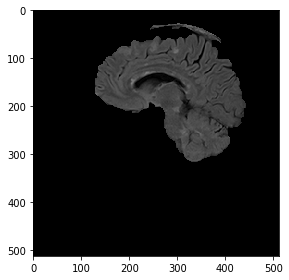

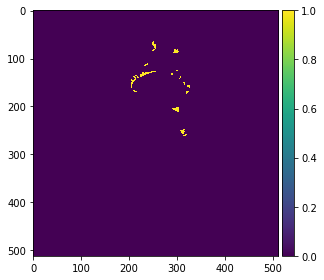

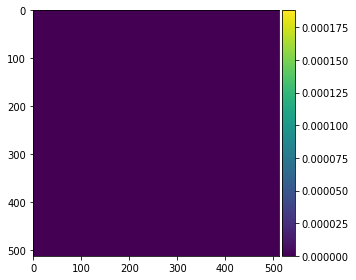

In [103]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[8])
plt.show()
imshow(np.squeeze(Y_train[8]))
plt.show()
imshow(np.squeeze(preds_train[8]))
plt.show()